<a href="https://colab.research.google.com/github/pooriaazami/deep_learning_class_notebooks/blob/main/10_RNN_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [76]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader

import numpy as np
import matplotlib.pyplot as plt

from tqdm.notebook import tqdm

In [131]:
LR = 1e-2
BATCH_SIZE = 8
EPOCHS = 10

In [132]:
# main source: https://github.com/golamSaroar/tensorflow-in-practice-specialization/blob/master/4-sequences-timeseries-and-prediction/9-LSTM.ipynb
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

window_size = 20

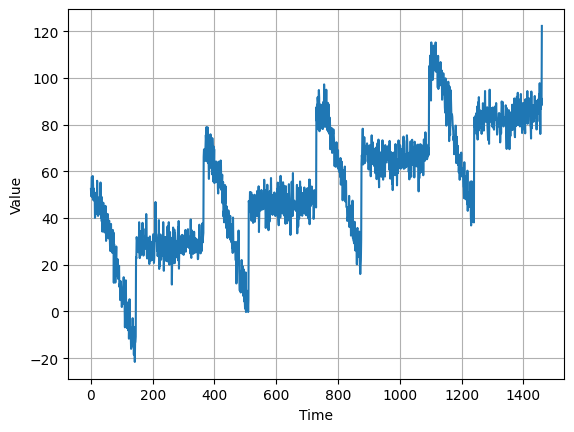

In [133]:
plot_series(time, series)

In [134]:
train_x = []
train_y = []

for i in range(len(series) - 20):
  x, y = series[i:i+20], series[i+20]
  train_x.append(x)
  train_y.append(y)

In [135]:
def base_line_prediction(train_x):
  preds = np.array([x[-1] for x in train_x])
  return preds

In [136]:
base_line_pred_values = base_line_prediction(train_x)

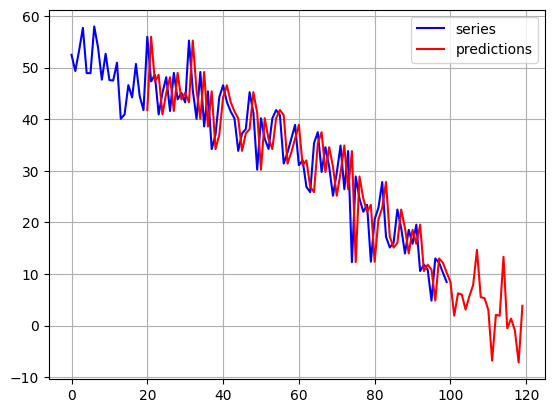

In [137]:
limit = 100
plt.plot(time[:limit], series[:limit], color='blue', label='series')
plt.plot(time[-len(base_line_pred_values):][:limit], base_line_pred_values[:limit], color='red', label='predictions')
plt.grid(True)
plt.legend()
plt.show()

In [138]:
def loss_function(preds, labels):
  return np.mean(np.power(preds - labels, 2))

In [139]:
base_line_loss = loss_function(base_line_pred_values, np.array(train_y))
print(f'Base line error: {base_line_loss:.2f}')

Base line error: 57.52


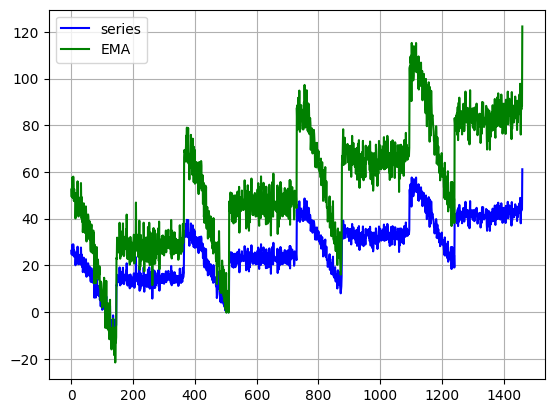

In [140]:
alpha = .5
moving_average = [0]
moving_average = [moving_average[-1] * (1 - alpha) + x * alpha for x in series]
moving_average = np.array(moving_average)

plt.plot(time, moving_average, color='blue', label='series')
plt.plot(time, series, color='green', label='EMA')
plt.grid(True)

plt.legend()
plt.show()

In [141]:
class Network(nn.Module):
  def __init__(self, hidden_dim=64, num_rnn_layers=1):
    super().__init__()
    self.__hidden_dim = hidden_dim
    self.__num_rnn_layers = num_rnn_layers
    self.rnn = nn.RNN(input_size=1,
                      hidden_size=self.__hidden_dim,
                      num_layers=self.__num_rnn_layers,
                      batch_first=True)
    self.fc = nn.Linear(in_features=self.__hidden_dim, out_features=1)


  def forward(self, x):
    batch_size, _, input_size = x.size()
    # print(x.size())
    first_hidden = torch.zeros(self.__num_rnn_layers, batch_size, self.__hidden_dim)

    x, _ = self.rnn(x, first_hidden)
    x = self.fc(x[:, -1])
    return x

In [142]:
class WindowDataset(Dataset):
  def __init__(self, x, y):
    self.x = x
    self.y = y

  def __len__(self):
    return len(x)

  def __getitem__(self, idx):
    return self.x[idx], self.y[idx]

In [143]:
train_x = np.array(train_x).reshape((-1, 20, 1))
train_y = np.array(train_y).reshape((-1, 1))

train_x = torch.from_numpy(train_x)
train_y = torch.from_numpy(train_y)

In [144]:
dataset = WindowDataset(train_x, train_y)
dataloader = DataLoader(dataset, batch_size=BATCH_SIZE, shuffle=True)

In [145]:
network = Network()

In [146]:
loss_function = nn.MSELoss()
optimizer = optim.Adam(network.parameters(), lr=LR)

In [147]:
for i in range(1, EPOCHS + 1):
  print(f'Epoch {i}/{EPOCHS}')

  total_loss = .0
  for x, y in tqdm(dataloader):
    optimizer.zero_grad()

    preds = network(x)

    loss = loss_function(preds, y)
    loss.backward()
    optimizer.step()

    total_loss += loss.detach().item()

  print(f'loss: {total_loss:.2f}')

Epoch 1/10


  0%|          | 0/3 [00:00<?, ?it/s]

loss: 8177.64
Epoch 2/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 2074.91
Epoch 3/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 2007.99
Epoch 4/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1946.76
Epoch 5/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1890.93
Epoch 6/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1840.65
Epoch 7/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1794.52
Epoch 8/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1751.31
Epoch 9/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1709.21
Epoch 10/10


  0%|          | 0/1 [00:00<?, ?it/s]

loss: 1666.55
